# Rozpoznawanie ocen końcowych

## 1. Opis problemu

Dane zostały zebrane za pomocą przeprowadzonych ankiet rozwiązanych przez uczniów matematyki i języka portugalskiego w szkole średniej. Dane zawierają wiele interesujących socjalnych, płciowych i naukowych informacji na temat uczniów. Naszym zadaniem jest, wykorzystując wiedzę zdobytą na laboratoriach, by za pomocą tych danych przewidzieć końcową ocenę studentów. Korzystać będziemy z danych uzyskanych dzięki uczniom matematyki.

## 2. Przygotowanie środowiska

In [70]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn import tree

## 3. Wczytanie danych

In [71]:
df = pd.read_csv('student-mat.csv')

## 4. Podstawowe parametry danych

In [72]:
l_obiektow = df.shape[0]
l_atrybutow = df.columns.size

print('Liczba obiektów: {}'.format(l_obiektow))
print('Liczba atrybutów: {}\n'.format(l_atrybutow))

Liczba obiektów: 395
Liczba atrybutów: 33



## 5. Przygotowanie danych

In [73]:
l_brakow = df.isnull().sum().sum()

print('Brakująca liczba danych: {}\n'.format(l_brakow))

Brakująca liczba danych: 0



Jak widać powyżej nie brakuje żadnych danych, więc nie musimy usuwać wierszy, ani kolumn. Przechodzimy więc do analizy danych.

## 6. Zakres zmienności poszczególnych danych

In [74]:
df.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


Jak widać powyżej nie wszystkie dane zostały uwzględnione. Prawdopodobnie wynika to z tego, iż pozostałe dane nie posiadają wartości liczbowych. Sprawdźmy więc jakiego typu są nasze dane.

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
school        395 non-null object
sex           395 non-null object
age           395 non-null int64
address       395 non-null object
famsize       395 non-null object
Pstatus       395 non-null object
Medu          395 non-null int64
Fedu          395 non-null int64
Mjob          395 non-null object
Fjob          395 non-null object
reason        395 non-null object
guardian      395 non-null object
traveltime    395 non-null int64
studytime     395 non-null int64
failures      395 non-null int64
schoolsup     395 non-null object
famsup        395 non-null object
paid          395 non-null object
activities    395 non-null object
nursery       395 non-null object
higher        395 non-null object
internet      395 non-null object
romantic      395 non-null object
famrel        395 non-null int64
freetime      395 non-null int64
goout         395 non-null int64
Dalc          395 no

Niektóre atrybuty są typu obiekt, więc nie są uwzględnione powyżej. Atrybuty typu obiekt możemy zastąpić wartościami liczbowymi. Dzięki temu będziemy mogli przeprowadzić analizę na wszystkich danych.

## 7. Przygotowanie danych do analizy atrybutów i zbadania korelacji

By atrybuty typu obiekt zastąpić wartościami liczbowymi użyjemy mapowania. Ta prosta metoda pozwoli nam na dalszą analizę atrybutów. 

In [76]:
df = pd.read_csv('student-mat.csv')

school = {'GP': 0, 'MS': 1}
df.school = df.school.map(school)

sex = {'F': 0, 'M': 1}
df.sex = df.sex.map(sex)

address = {'R': 0, 'U': 1}
df.address = df.address.map(address)

famsize = {'LE3': 0, 'GT3': 1}
df.famsize = df.famsize.map(famsize)

Pstatus = {'A': 0, 'T': 1}
df.Pstatus = df.Pstatus.map(Pstatus)

Mjob = {'teacher': 0, 'health': 1, 'services': 2, 'at_home': 3, 'other': 4}
df.Mjob = df.Mjob.map(Mjob)

Fjob = {'teacher': 0, 'health': 1, 'services': 2, 'at_home': 3, 'other': 4}
df.Fjob = df.Fjob.map(Fjob)

guardian = {'mother': 0, 'father': 1, 'other': 2}
df.guardian = df.guardian.map(guardian)

schoolsup = {'no': 0, 'yes': 1}
df.schoolsup = df.schoolsup.map(schoolsup)

famsup = {'no': 0, 'yes': 1}
df.famsup = df.famsup.map(famsup)

paid = {'no': 0, 'yes': 1}
df.paid = df.paid.map(paid)

activities = {'no': 0, 'yes': 1}
df.activities = df.activities.map(activities)

nursery = {'no': 0, 'yes': 1}
df.nursery = df.nursery.map(nursery)

higher = {'no': 0, 'yes': 1}
df.higher = df.higher.map(higher)

internet = {'no': 0, 'yes': 1}
df.internet = df.internet.map(internet)

romantic = {'no': 0, 'yes': 1}
df.romantic = df.romantic.map(romantic)

## 8. Zakres zmienności z wykorzystaniem wszystkich atrybutów

In [119]:
df.describe()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,0.116456,0.473418,16.696203,0.777215,0.711392,0.896203,2.749367,2.521519,2.483544,2.956962,0.389873,1.448101,2.035443,0.334177,0.129114,0.612658,0.458228,0.508861,0.794937,0.949367,0.832911,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190
std,0.321177,0.499926,1.276043,0.416643,0.453690,0.305384,1.094735,1.088201,1.421948,1.294530,0.633176,0.697505,0.839240,0.743651,0.335751,0.487761,0.498884,0.500555,0.404260,0.219525,0.373528,0.472300,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443
min,0.000000,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,0.000000,0.000000,16.000000,1.000000,0.000000,1.000000,2.000000,2.000000,2.000000,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,0.000000,0.000000,17.000000,1.000000,1.000000,1.000000,3.000000,2.000000,3.000000,4.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,0.000000,1.000000,18.000000,1.000000,1.000000,1.000000,4.000000,3.000000,4.000000,4.000000,1.000000,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000
max,1.000000,1.000000,22.000000,1.000000,1.000000,1.000000,4.000000,4.000000,4.000000,4.000000,2.000000,4.000000,4.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


## 9. Wnioski z analizy atrybutów

1. Zdecydowana większość uczniów pochodzi ze szkoły Gabriel Pereira.
2. Wiekszość uczniów stanowią kobiety.
3. Większość uczniów pochodzi z obszarów miejskich.
4. Wiekszość uczniów ma niedaleko do szkoły. Prawodopodbnie wpływ na to ma skąd pochodzi uczeń. Logiczne jest to, że uczniowie pochodzący z obszarów miejskich będą miały bliżej.
5. Większość uczniów pochodzi z rodzin wielodzietnych.
6. Zazwyczaj za ucznia odpowiedzialna jest matka.
7. Prawie połowa uczniów uczęszcza na korepetycję.
8. Połowa uczniów uczęszcza na dodatkowe, pozaszkolne zajęcia.
9. Zdecydowania większość (praktycznie wszyscy uczniowie) chce kontyunować naukę po szkole średniej.
10. Uczniowie mają niemałą ilość czasu wolnego i również sporą część tego czasu przeznaczają na wyjście ze znajomymi.
11. Dzienne spożycie alkholu nie jest tak duże, weekendowe wzrasta jednak nie jest to duże spożycie.
12. Większość uczniów jest zdrowa.

## 10. Analiza korelacji

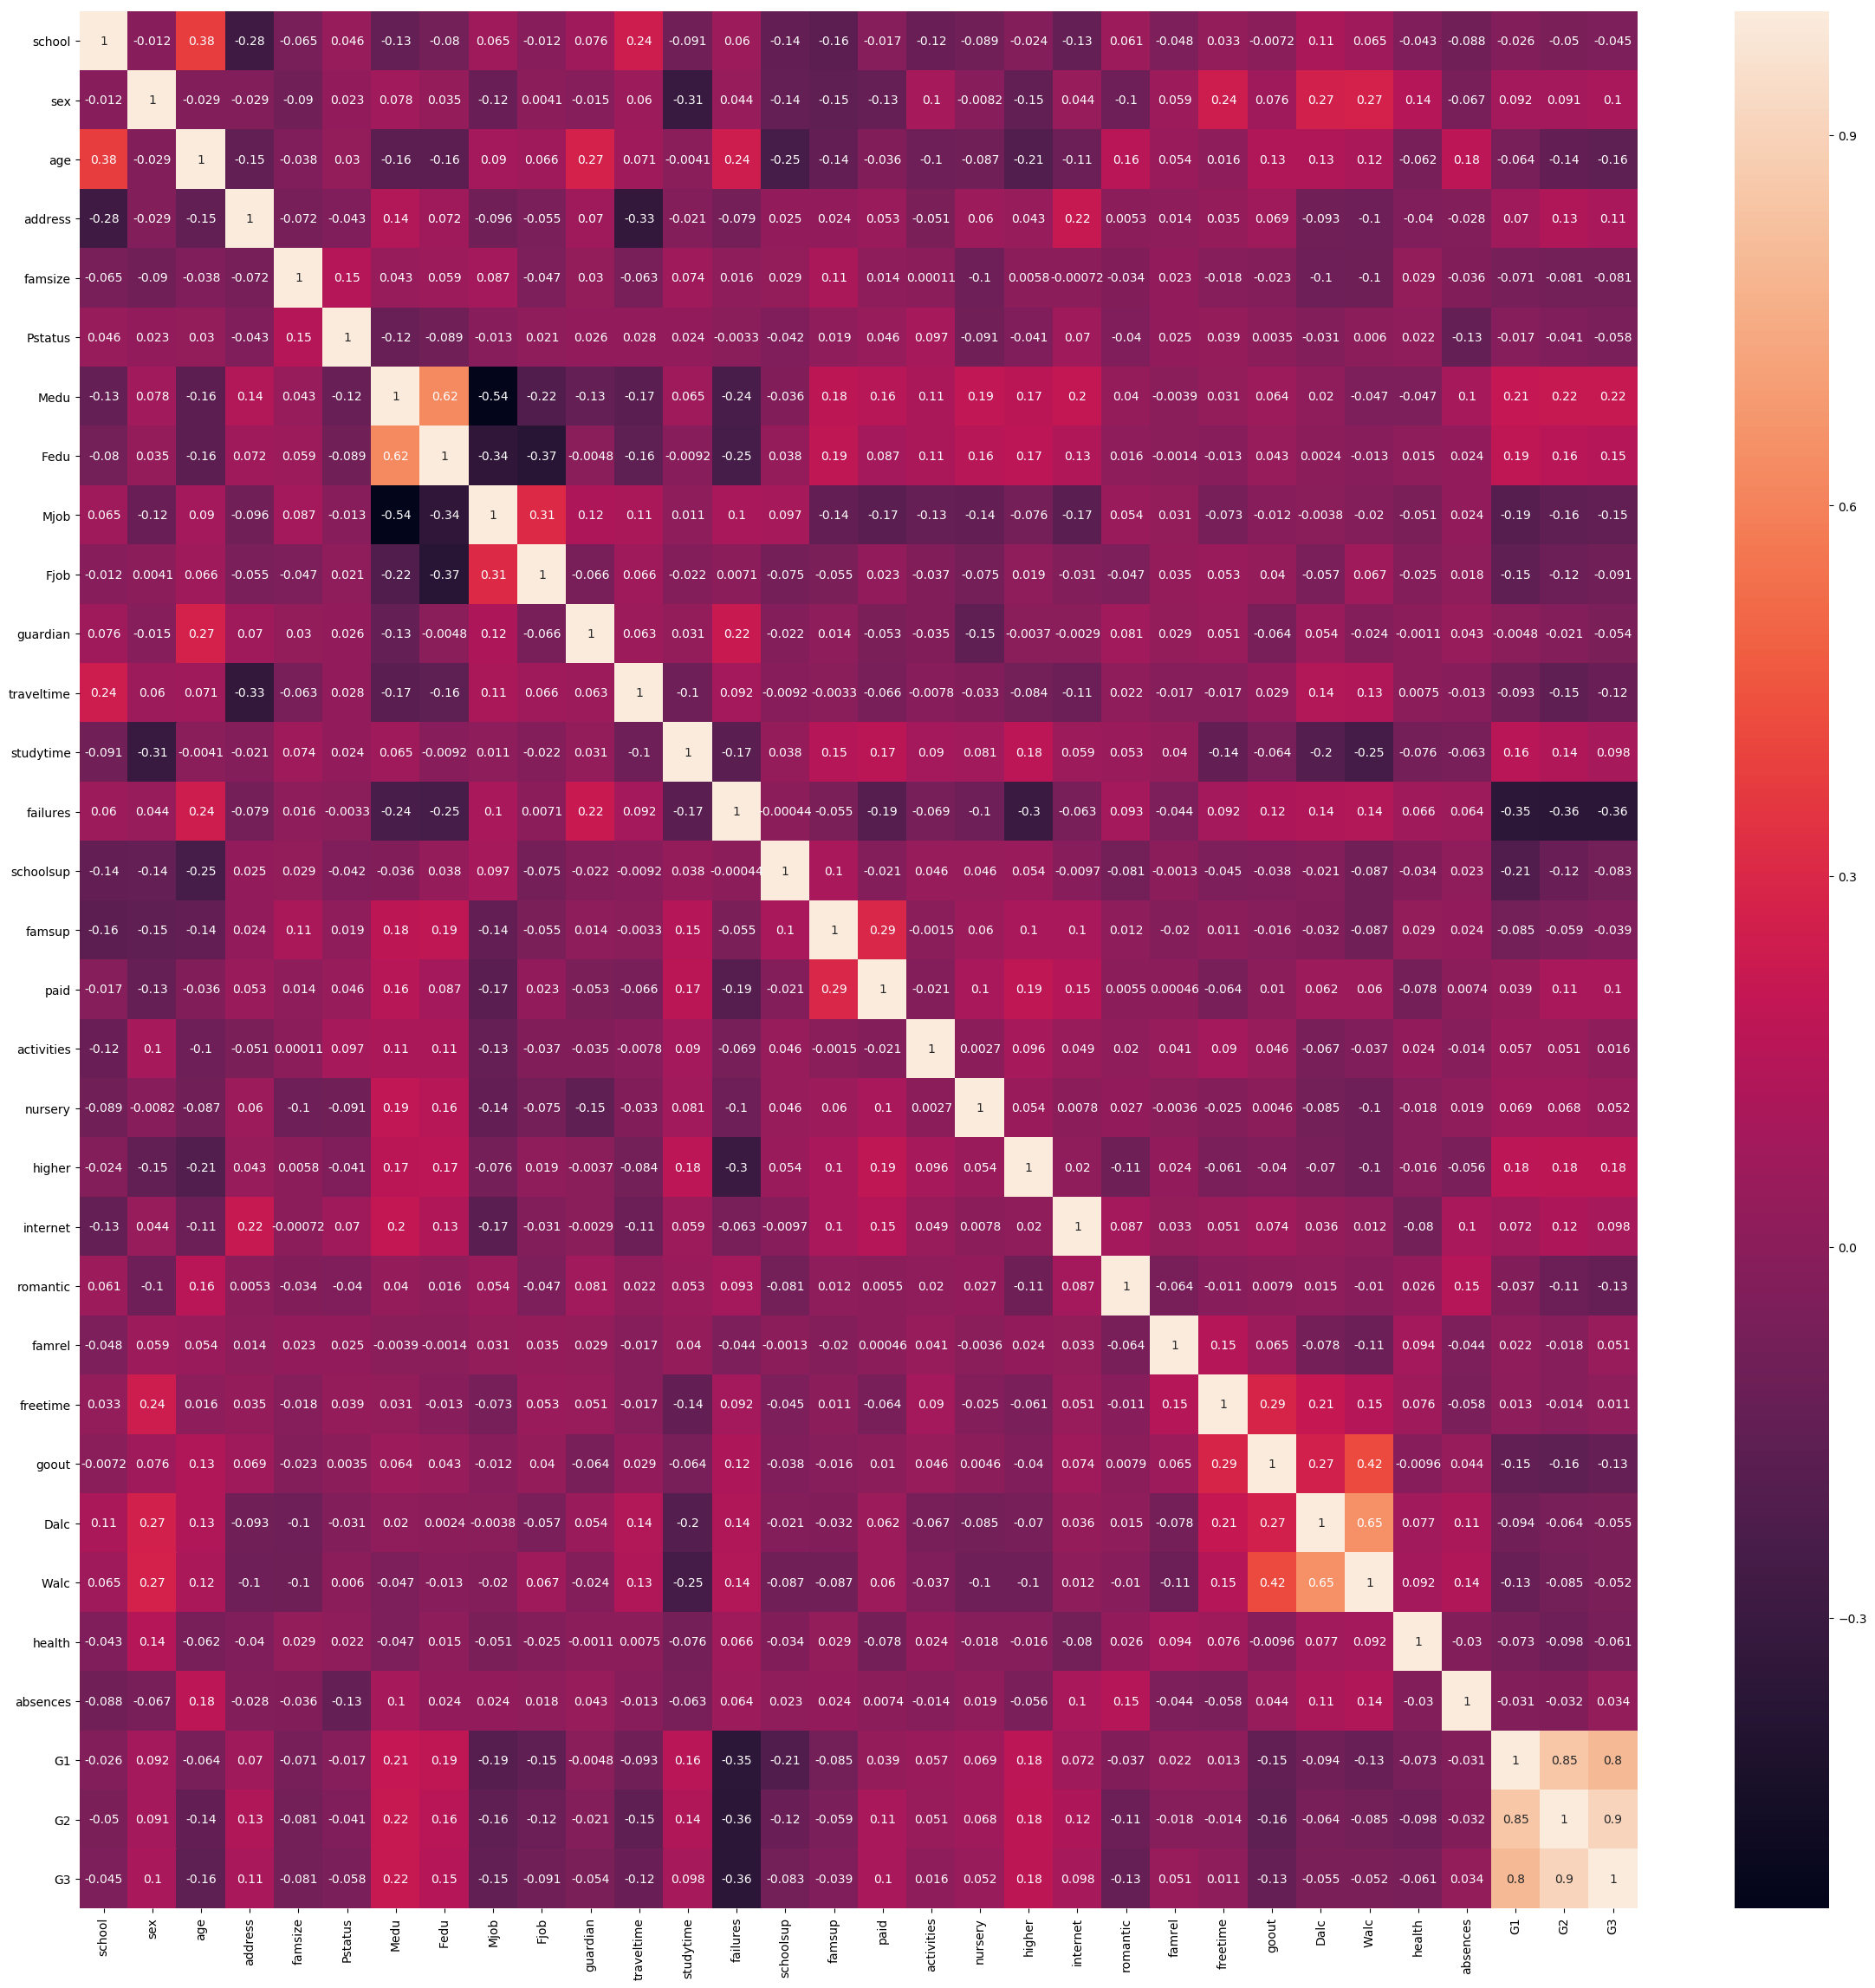

In [78]:
plt.figure(figsize=(29, 29), dpi = 100)
sns.heatmap(df.corr(), annot = df.corr())

#### Analiza korelacji atrybutów z ocenami

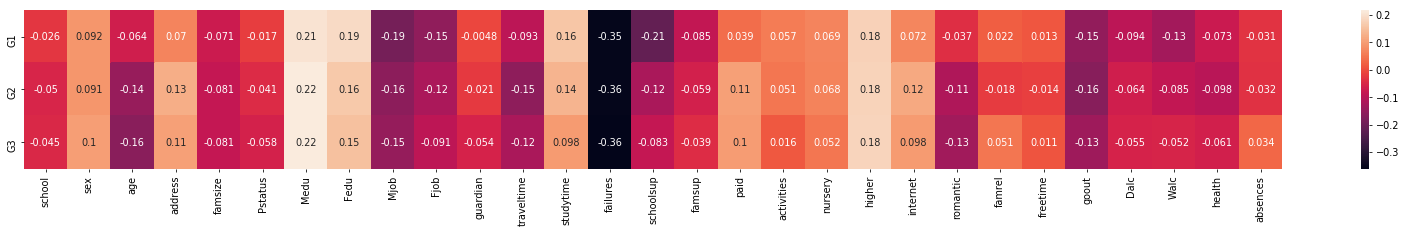

In [79]:
atrybutyZOcenami = df.corr().iloc[-3:, :-3]
plt.figure(figsize=(29, 3), dpi = 70)
sns.heatmap(atrybutyZOcenami, annot = atrybutyZOcenami)

#### Posortowana tabela z wpływem atrybutów na oceny

In [80]:
posortowanaKorelacja = atrybutyZOcenami.mean().abs().sort_values(ascending=False)
posortowanaKorelacja = pd.DataFrame(posortowanaKorelacja, columns=['Korelacja z ocenami'])
posortowanaKorelacja

,Korelacja z ocenami
failures,0.357009
Medu,0.212672
higher,0.179953
Fedu,0.169207
Mjob,0.163055
goout,0.148048
schoolsup,0.137593
studytime,0.131437
age,0.123045
traveltime,0.121127


## 11. Wnioski z analizy korelacji atrybutów

1. Największy wpływ na aktualną ocenę ucznia mają oceny z poprzednich lat. Jeśli uczeń uczył się dobrze to prawdopodobnie w przyszłości też się będzie dobrze uczył.
2. Ogromny wpływa na ocenę ma również ilość niezaliczonych lat szkoły. Im więcej tym gorsze oceny dostaje uczeń i tym mniejsza chęć zdobycia wyższego wykształcenia. 
3. Ciekawą korelacją jest wykształcenie rodziców. Małżonkowie zazwyczaj mają podobne wykształcenie.
4. Wykształcenie matki jest 3 najważniejszym czynnikiem wpływającym na oceny ucznia.
5. Wykształcenie ojca jest bardzo istotne, ale nie tak istotne jak chęć podjęcia dalszej eduakcji. Chęć podjęcia dalszej edukacji jest ważniejsza niż czas spędzony na nauce. Liczą się chęci.
6. Płeć ma bardzo duży wpływ na czas wolny i czas nauki. Kobiety spędzają więcej czasu na nauce, a mężczyźni mają więcej czasu wolnego. Przełożenie na wyniki w nauce jest nieznaczne.
7. Mężczyźni piją zdecydowanie więcej alkoholu w weekendy i w tygodniu. Spożycie alkoholu jest mocno skorelowane z wychodzeniem z domu, ale to wychodzenie z domu ma dużo silniejszą korelację ze słabszymi wynikami w nauce. 
8. Weekendowe spożycie alkoholu jest silnie skorelowane z czasem poświęcanym na naukę. 
9. Mało ważne jest to kto jest odpowiedzialny ze ucznia, jeżeli chodzi o przyszłe oceny. Widać jednak, że wiek ma znaczenie na to kto opiekuje się uczniem. Wraz ze wzrostem wieku opiekę przestają sprawować rodzice.
10. Osoba odpowiedzialna ma wpływ na ilość niezaliczonych lat. W większości przypadków odpowiedzialna jest matka lub ktoś inny. Osoba nie ma zbyt dużo wpływu na ocenę w przyszłych latach, ale ilość niezaliczonych lat już tak.
   

## 12. Parametry znaczące

Jako parametry znaczące wybraliśmy atrybuty, których korelacja jest większa niz 0.15 lub zbliżona do tej wartośći.

In [81]:
atrybutyZnaczace = list(list(posortowanaKorelacja.index[:6]))

print('Atrybuty znaczące:')
for i, v in enumerate(atrybutyZnaczace):
    print (v)

Atrybuty znaczące:
failures
Medu
higher
Fedu
Mjob
goout


## 13. Korelacja pomiędzy atrybutami znaczącymi

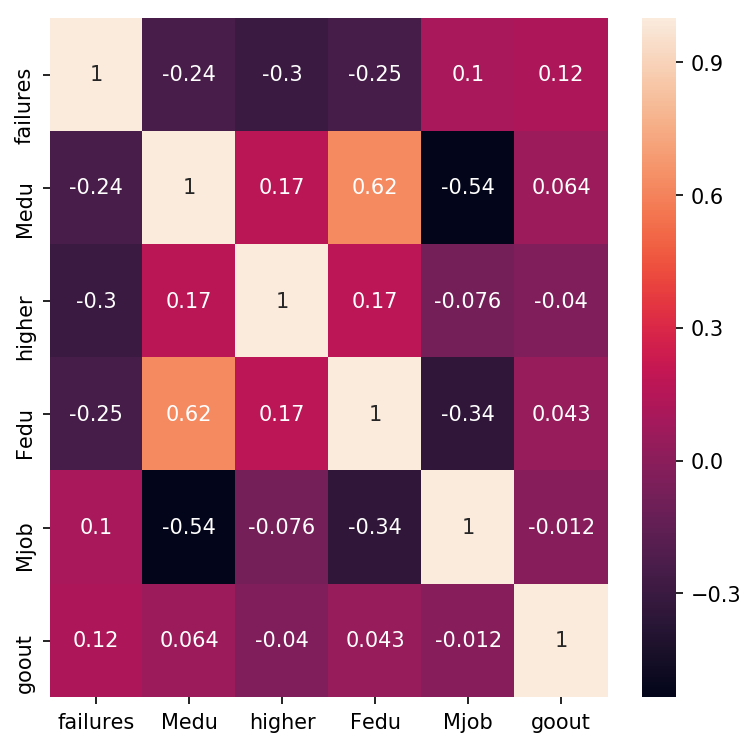

In [82]:
plt.figure(figsize=(6, 6), dpi = 150)
sns.heatmap(df[atrybutyZnaczace].corr(), annot=df[atrybutyZnaczace].corr())

## 14. Wnioski z analizy korelacji atrybutów znaczących.

1. Bardzo duży wpływ na siebie ma edukacja matki i edukacja ojca. Być może rodzice poznali się na uczelni lub połączyło ich zamiłowanie do danej dziedziny. 
2. Edukacja rodziców ma niemały wpływ na chęć podjęcia dalszej edukacji przez uczniów. Widać, że jeżeli rodzice są dobrze wykształceni to ich dzieci również chcą takie być.
3. Edukacja matki wpływa na jej pracę, co wydaję się być logiczne. Edukacja ojca również wpływa na jego obecną pracę lecz w mniejszym stopniu. Być może męzczyźni poszukują nowych wyzwań i są bardziej zmienni.

## 15. Grupowanie atrybutów znaczących??????

ValueError: `dataset` input should have multiple elements.

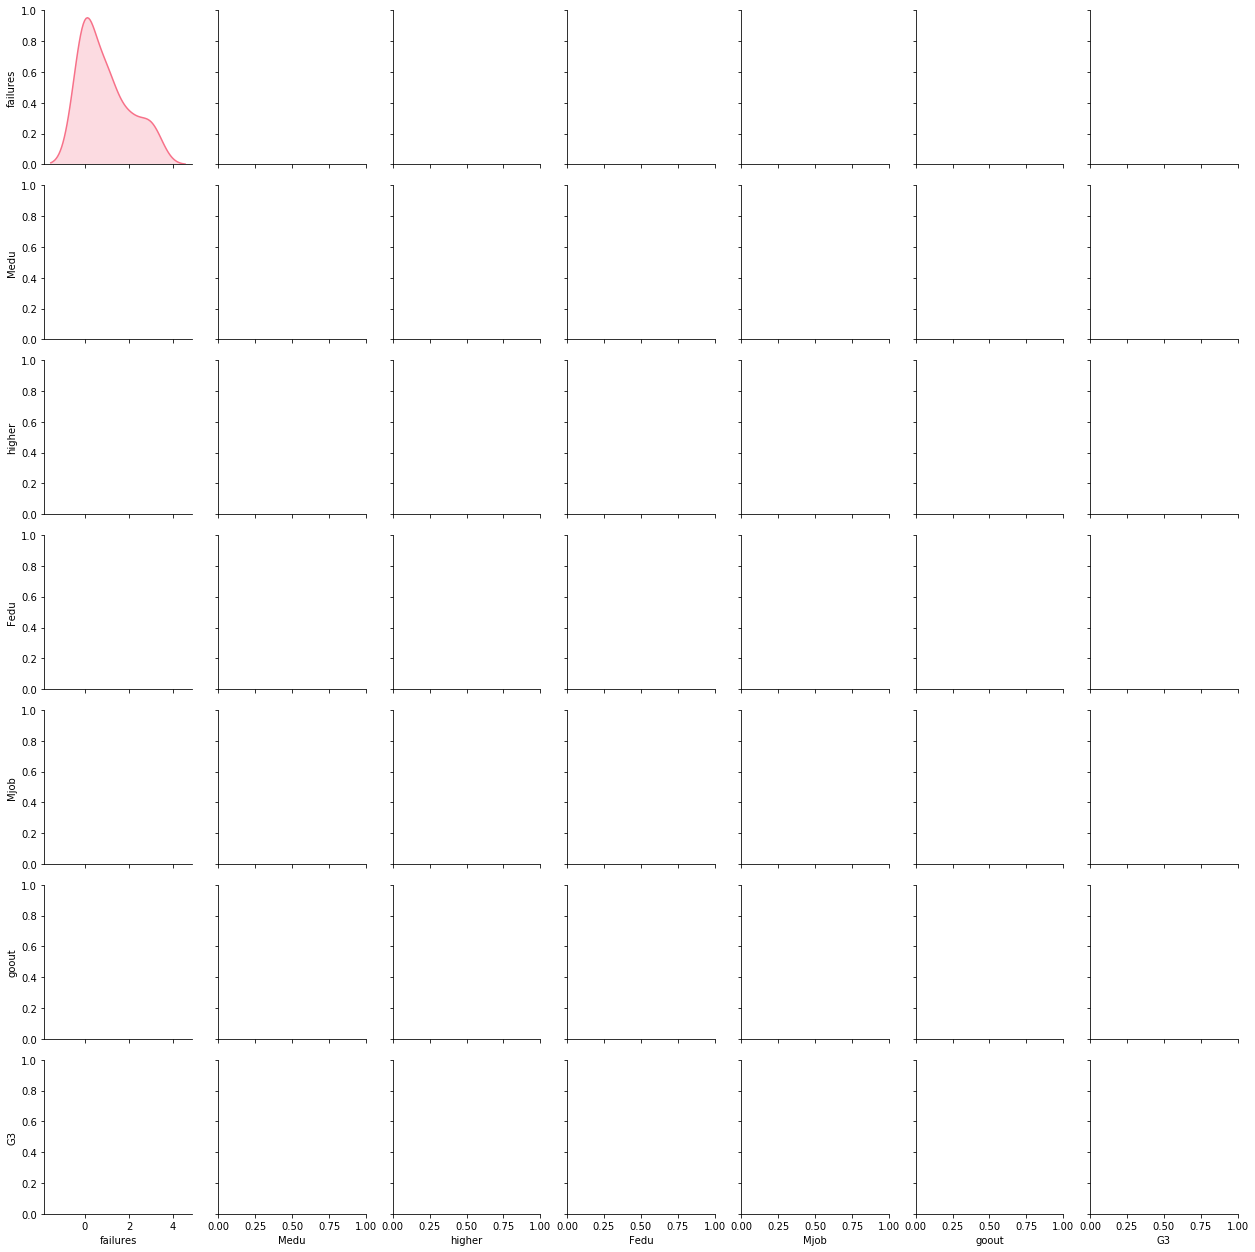

In [83]:
dfAtrZnaczacych = df[atrybutyZnaczace + [df.columns[-1]]]

sns.pairplot(dfAtrZnaczacych, kind='scatter', hue = 'G3')

# NIE WIEM CO Z TYM DALEJ, TRZEBA TO OGARNĄĆ.

## Wybór optymalnego klasyfikatora

In [ ]:
def podziel(df,proporcja):
    # dzieli macierz (ramkę) danych na zbiór uczacy i testowy
    # df - ramka danych; proporcja - proporcja podzialu (0-1)
    # zwraca słownik z kluczami:
    # opis_ucz/opis_test - macierz atrybutów opisujących zbioru uczącego/testowego
    # dec_ucz/dec_test - wektor wartosci atrybutu decyzyjnego zbioru uczącego/testowego
    # uwaga: atrybut opisujący jest zawsze na końcu (ostatnia kolumna ramki)
    opis_ucz, opis_test, dec_ucz, dec_test = train_test_split(df.iloc[:,0:-1], df.iloc[:,-1].astype('category').cat.codes, test_size=proporcja)#, random_state=0)
    return {"opis_ucz":opis_ucz, "opis_test":opis_test, "dec_ucz":dec_ucz, "dec_test":dec_test}


dane = podziel(df,0.3)
print('Liczba obiektów zbioru uczącego: ', len(dane["opis_ucz"]))
print('Liczba obiektów zbioru testowego: ', len(dane["opis_test"]))

In [114]:
# Model Klasyfikatora
model = KNeighborsClassifier(n_neighbors=1)

In [95]:
def weryfikuj(model,dane,atryb):
    # wyswietla wynik weryfikacji klasyfikatora w postaci macierzy pomyłek
    # dla zbioru uczącego i testowego
    # model - model klasyfikatora
    # dane - dane (słownik zwracany przez funkcje podziel)
    # atryb - lista atrybutów uwzględnianych w weryfikacji
    model.fit(dane["opis_ucz"].iloc[:,atryb], dane["dec_ucz"])
    wynik_ucz = model.predict(dane["opis_ucz"].iloc[:,atryb])
    wynik_test = model.predict(dane["opis_test"].iloc[:,atryb])
    print("Macierz pomyłek dla zbioru uczącego")
    print(pd.crosstab(dane["dec_ucz"],wynik_ucz)) 
    print("Macierz pomyłek dla zbioru testowego")
    print(pd.crosstab(dane["dec_test"],wynik_test))

    
def granice(model,dane,atr_x, atr_y,tytul,kontur = 1):
    # wyswietla granice decyzyjne
    # model - model klasyfikatora
    # dane - dane (słownik zwracany przez funkcje podziel)
    # atr_x/atr_y - artybut wyswietlany na osi x/y
    # tytul - wyswietlany tytul wykresu
    # kontur - par. opcjonalny (=0 -> brak konturu)
    if (kontur == 1):    
        model.fit(dane["opis_ucz"].iloc[:,[atr_x,atr_y]], dane["dec_ucz"])
        x_min = min(dane["opis_ucz"].iloc[:, atr_x].min(),dane["opis_test"].iloc[:, atr_x].min())
        x_max = max(dane["opis_ucz"].iloc[:, atr_x].max(),dane["opis_test"].iloc[:, atr_x].max())
        y_min = min(dane["opis_ucz"].iloc[:, atr_y].min(),dane["opis_test"].iloc[:, atr_y].min())
        y_max = max(dane["opis_ucz"].iloc[:, atr_y].max(),dane["opis_test"].iloc[:, atr_y].max())
        rozst_x = x_max - x_min
        rozst_y = y_max - y_min
        x_min = x_min - 0.1*rozst_x
        x_max = x_max + 0.1*rozst_x
        y_min = y_min - 0.1*rozst_y
        y_max = y_max + 0.1*rozst_y       
        xx, yy = np.meshgrid(np.arange(x_min, x_max, (x_max-x_min)/150),
                     np.arange(y_min, y_max, (y_max-y_min)/150))
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
    plt.figure(dpi = 100)
    plt.title(tytul)
    if (kontur == 1):
        plt.contourf(xx, yy, Z, levels = 4, alpha=0.2)
    plt.scatter(dane["opis_ucz"].iloc[:, atr_x], dane["opis_ucz"].iloc[:, atr_y], c=dane["dec_ucz"], marker = '.')
    plt.scatter(dane["opis_test"].iloc[:, atr_x], dane["opis_test"].iloc[:, atr_y], c=dane["dec_test"], marker = 'x')    

In [115]:
# podział zbioru danych
d = podziel(df,0.3)
# zdefiniowanie modelu klasyfikatora
# weryfikacja
weryfikuj(model,d,range(len(atrybutyZnaczace)))

Macierz pomyłek dla zbioru uczącego
col_0  0   2   3   5   6   7   8   9   10  11  12  13  14  15  17
row_0                                                            
0       8   0   0   3   1   0   0   0   4   5   4   0   0   1   2
2       2   2   0   1   0   0   0   0   0   1   0   0   0   0   1
3       2   0   2   1   0   2   1   0   1   1   2   0   0   0   0
4       1   1   0   0   1   0   1   0   1   1   1   0   0   0   0
5       0   0   0   5   0   2   0   0   3   3   2   2   0   0   1
6       2   0   1   4   4   1   0   0   3   2   3   1   0   0   0
7       4   1   1   4   0  13   1   1   1   6   2   0   0   2   3
8       3   0   1   0   0   1   8   0   1   5   3   0   0   5   1
9       2   0   0   1   0   2   0   4   2   4   0   0   0   2   4
10      2   1   2   3   1   1   0   0   8   3   0   0   0   1   1
11      1   1   0   1   0   0   0   0   1  10   1   0   0   2   1
12      1   0   0   3   0   0   0   0   2   1   9   0   0   5   3
13      2   0   1   0   1   0   0   1   

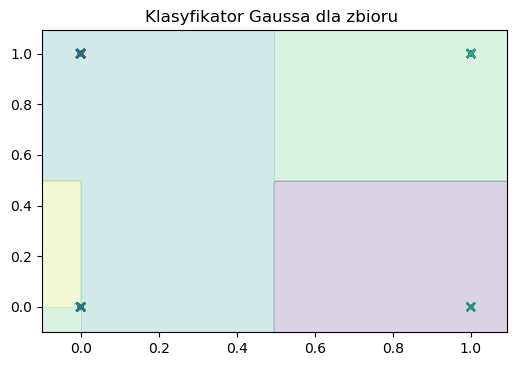

In [116]:
ax, ay = 0,1
# granice decyzyjne
granice(model,d,ax,ay,"Klasyfikator Gaussa dla zbioru ")

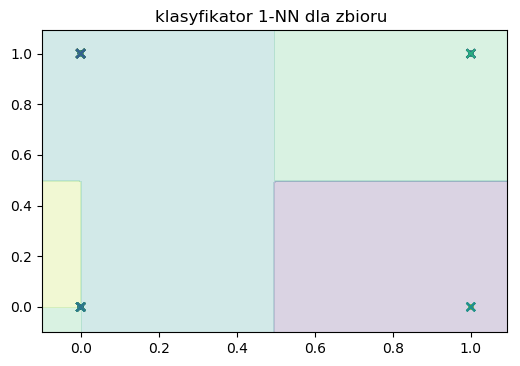

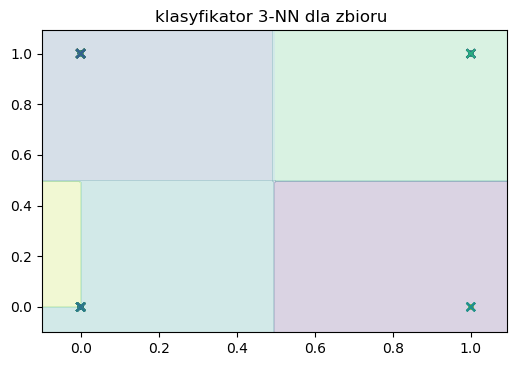

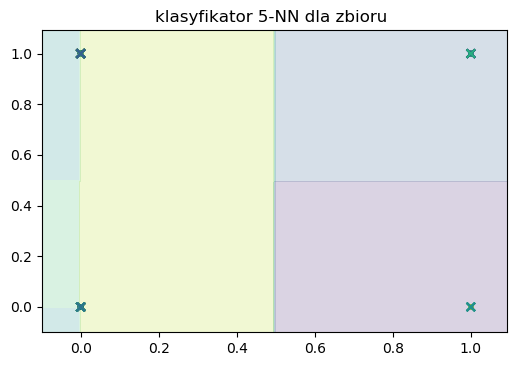

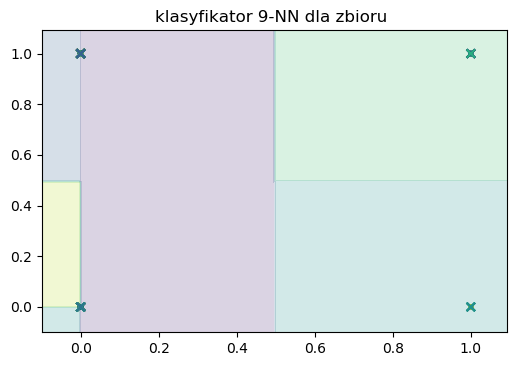

In [117]:
for k in [1,3,5,9]:
    model_knn = KNeighborsClassifier(n_neighbors=k)
    granice(model_knn,d,0,1,"klasyfikator " + str(k)+ "-NN dla zbioru ")

## Ocena klasyfikacji

## Wnioski